## RUN SBI-SGM in alpha, new bounds, new SGM, only three parameters needed

parameters order is  :tauG,speed,alpha (In second)

Use Annealing


## Import some pkgs

In [2]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange, tqdm
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from scipy.optimize import dual_annealing

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np
from utils.measures import reg_R_fn, lin_R_fn
from joblib import Parallel, delayed

In [4]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

## Some fns

In [5]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x));
# transfer vec to a sym mat
def vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

### Some parameters

In [6]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values;

In [7]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]

In [9]:
paras = edict()

paras.save_prefix = "rawfc2"
paras.band = "alpha" 
paras.freqrange =  np.linspace(_paras[paras.band][0], _paras[paras.band][1], 5)
print(paras.freqrange)
#paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
#paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
#paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["TauC", "Speed", "alpha"]
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.add_v = 0.01
paras.nepoch = 100
paras.k = 1

paras.bounds = [
    (-10, 10), 
    (-10, 10), 
    (-10, 10), 
]

[ 8.  9. 10. 11. 12.]


In [10]:
# fn for reparemetering
_map_fn_np = partial(logistic_np, k=paras.k)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=paras.k), prior_bds=paras.prior_bds);

### Load the data

In [11]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn

if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.01 on diag


In [12]:
# em FC
fc_root = RES_ROOT/"emp_fcs2"
def _get_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{paras.band}*{paras.nepoch}/sub{sub_ix}.pkl"))[0]
    return load_pkl(fil, verbose=False)

fcs = np.array([_get_fc(sub_ix, paras.band) for sub_ix in range(36)]);

## Annealing

In [13]:
def simulator(raw_params, brain, prior_bds, freqrange):
    params = _map_fn_np(raw_params)*(prior_bds[:, 1]-prior_bds[:, 0]) + prior_bds[:, 0]
    
    params_dict = dict()
    params_dict["tauC"] =  params[0]
    params_dict["speed"] =  params[1]
    params_dict["alpha"] =  params[2]
    modelFC = build_fc_freq_m(brain , params_dict, freqrange)
    modelFC_abs = np.abs(modelFC[:68, :68])
    res = _minmax_vec(modelFC_abs[np.triu_indices(68, k = 1)])
    return res, modelFC

In [14]:
def _obj_fn(raw_params, empfc, simulator_sp):
    empfc = np.abs(empfc)
    emp_res = _minmax_vec(empfc[np.triu_indices(68, k = 1)])
    simu_res = simulator_sp(raw_params)[0] # it is after minmax
    rv = -lin_R_fn(simu_res, emp_res)[0]
    return rv

In [15]:
brains = []
for sub_idx in range(36):
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, sub_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brains.append(brain)
    

In [16]:
def _run_fn(sub_idx):
    # brain
    brain = brains[sub_idx]
    # empfc
    empfc = fcs[sub_idx]
    
    simulator_sp = partial(simulator, 
                           brain=brain, 
                           prior_bds=paras.prior_bds, 
                           freqrange=paras.freqrange)
    res = dual_annealing(_obj_fn, 
                         x0=np.array([0, 0, 0]),
                         bounds=paras.bounds, 
                         args=(empfc, simulator_sp), 
                         maxiter=50,
                         initial_temp=5230.0,
                         seed=24,
                         visit=2.62,
                         no_local_search=False)
    save_res = edict()
    save_res.bestfc = simulator_sp(res.x)[1]
    save_res.ann_res = res
    
    save_fil = f"{paras.save_prefix}_ANN_{paras.band}_ep{paras.nepoch}_" + \
                   f"addv{paras.add_v*100:.0f}" +\
                   f"/ind{sub_idx}.pkl"
    save_pkl(RES_ROOT/save_fil, save_res)
    return save_res

In [16]:
with Parallel(n_jobs=10) as parallel:
     _ = parallel(delayed(_run_fn)(sub_idx)  
                  for sub_idx in tqdm(range(36), total=36))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:31<00:00,  2.54s/it]


## Analysis

In [154]:
band = "alpha"
fils = RES_ROOT/f"rawfc2newv2_ANN_{band}_ep100_addv1"
fils = list(fils.glob("*.pkl"));
sfil1s = sorted(fils, key=lambda fil: int(fil.stem.split("ind")[-1]));

fils = RES_ROOT/f"rawfc2_ANN_{band}_ep100_addv1"
fils = list(fils.glob("*.pkl"));
sfil2s = sorted(fils, key=lambda fil: int(fil.stem.split("ind")[-1]));



In [155]:
idx = 20
linrs = []
for idx in range(36):
    res1 =  load_pkl(sfil1s[idx], verbose=False)
    res2 =  load_pkl(sfil2s[idx], verbose=False);
    linrs.append((-res1.ann_res.fun, -res2.ann_res.fun))
linrs = np.array(linrs);
linrs.mean(axis=0)

array([0.3257145 , 0.33886619])

In [156]:
idx = 20
linrs = []
all_vs1 = []
all_vs2 = []
for idx in range(36):
    res1 =  load_pkl(sfil1s[idx], verbose=False)
    res2 =  load_pkl(sfil2s[idx], verbose=False)
    #print(res1.ann_res.x, res2.ann_res.x)
    all_vs1.append(logistic_np(res1.ann_res.x, k=1))
    all_vs2.append(logistic_np(res2.ann_res.x, k=1))
all_vs1 = np.array(all_vs1)
all_vs2 = np.array(all_vs2);

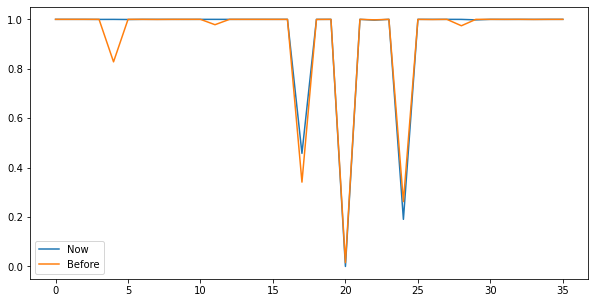

In [157]:
idx = 1
plt.figure(figsize=[10, 5])
plt.plot(all_vs1[:, idx], label="Now")
plt.plot(all_vs2[:, idx], label="Before")
plt.legend()